#  ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard
*Introduce dataset here*

# Import notebook dependencies

In [1]:
import os
import xarray as xr
import numpy as np
import warnings # Remove warnings to improve display
warnings.filterwarnings('ignore')

# Import utils 
from utils.data_utils import read_is2_data, read_book_data
from utils.wrangling_utils import getWinterDateRange, is2_interp2d
from utils.plotting_utils import plotArcticMap, arcticComparisonMaps

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

# Solves weird line at pole in cartopy
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

# Set desired date range 
Our analysis looks at winter data, so we'll only load data for the Northern Hemisphere winter season (Nov-Apr)

In [2]:
start_year = "2018"
end_year = "2020"
winter_months = getWinterDateRange(start_year, end_year)
print(winter_months)

DatetimeIndex(['2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', freq=None)


# Read data

In [3]:
is2_ds = read_is2_data() # Read in data
is2_ds = is2_ds.sel(time = winter_months) # Get winter months
print(is2_ds)

<xarray.Dataset>
Dimensions:            (time: 12, x: 304, y: 448)
Coordinates:
    longitude          (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    latitude           (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    xgrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    ygrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
  * time               (time) datetime64[ns] 2018-11-01 ... 2020-04-01
Dimensions without coordinates: x, y
Data variables:
    projection         (time) int32 -2147483647 -2147483647 ... -2147483647
    ice_thickness      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments       (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month  (time, y, x) float32 dask.array<chunksize=(1, 448, 304

# Set interpolation preferences  
The dataset included uninterpolated data, or we can interpolate the data using a simple nearest neighbor interpolation function. Because ICESat-2 doesn't provide full monthly coverage, interpolating fills missing grid cells with a best guess based on surrounding data. This helps avoid sampling biases when performing time series analyses, with the cavaet that this interpolation method is subjective. <br><br>
In order to definte the interpolation bounds (so that we don't try and interpolate over land, or other areas where there wouldn't be sea ice!), we use the [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://nsidc.org/data/g02202) dataset to infer the location of the sea ice. A version of this dataset is included in the netcdf file associated with the jupyter book and downloaded in the code cells below. 

In [4]:
interpolate = True 

if (interpolate == True): 
    cdr_da = read_book_data()["seaice_conc_monthly_cdr"] # Get CDR data
    cdr_da = cdr_da.sel(time = winter_months) # Get winter months
    is2_ds = is2_interp2d(is2_ds, cdr_da, method='nearest', interp_var='all')

# Plot mean winter ice thickness
Using the cartopy mapping package for python, we overlay mean ice thickness for each winter season on a basemap of the Arctic.

In [5]:
thickness = is2_ds["ice_thickness"]

## Winter 2018-19

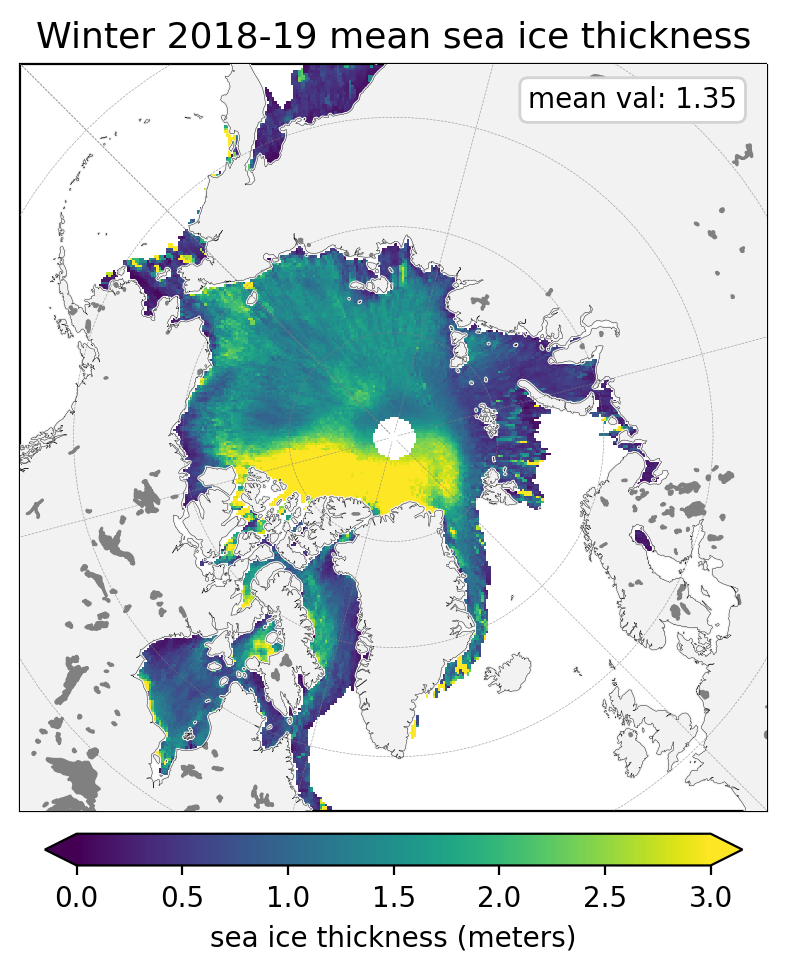

In [6]:
# Compute mean thickness for winter 1 (Nov 2018 - Apr 2019)
thickness_av_winter1 = thickness.sel(time=slice("Nov 2018", "Apr 2019")).mean(dim = ["time"])
thickness_av_winter1 = thickness_av_winter1.assign_attrs(thickness.attrs)

# Plot
plotArcticMap(thickness_av_winter1, minval=0, maxval=3, title="Winter 2018-19 mean sea ice thickness")

## Winter 2019-20

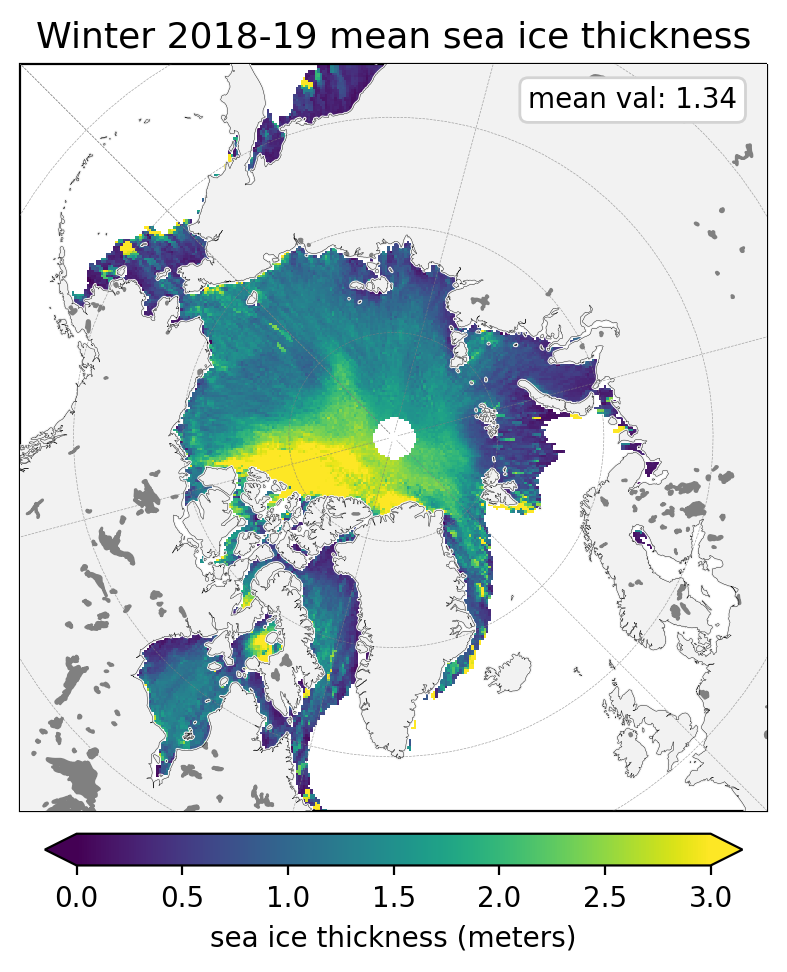

In [7]:
# Compute mean thickness for winter 2 (Nov 2019 - Apr 2020)
thickness_av_winter2 = thickness.sel(time=slice("Nov 2019", "Apr 2020")).mean(dim = ["time"])
thickness_av_winter2 = thickness_av_winter2.assign_attrs(thickness.attrs)

# Plot
plotArcticMap(thickness_av_winter2, minval=0, maxval=3, title="Winter 2018-19 mean sea ice thickness")

## Seasonal change 
Visualize the seasonal change in ice thickness between two winters 

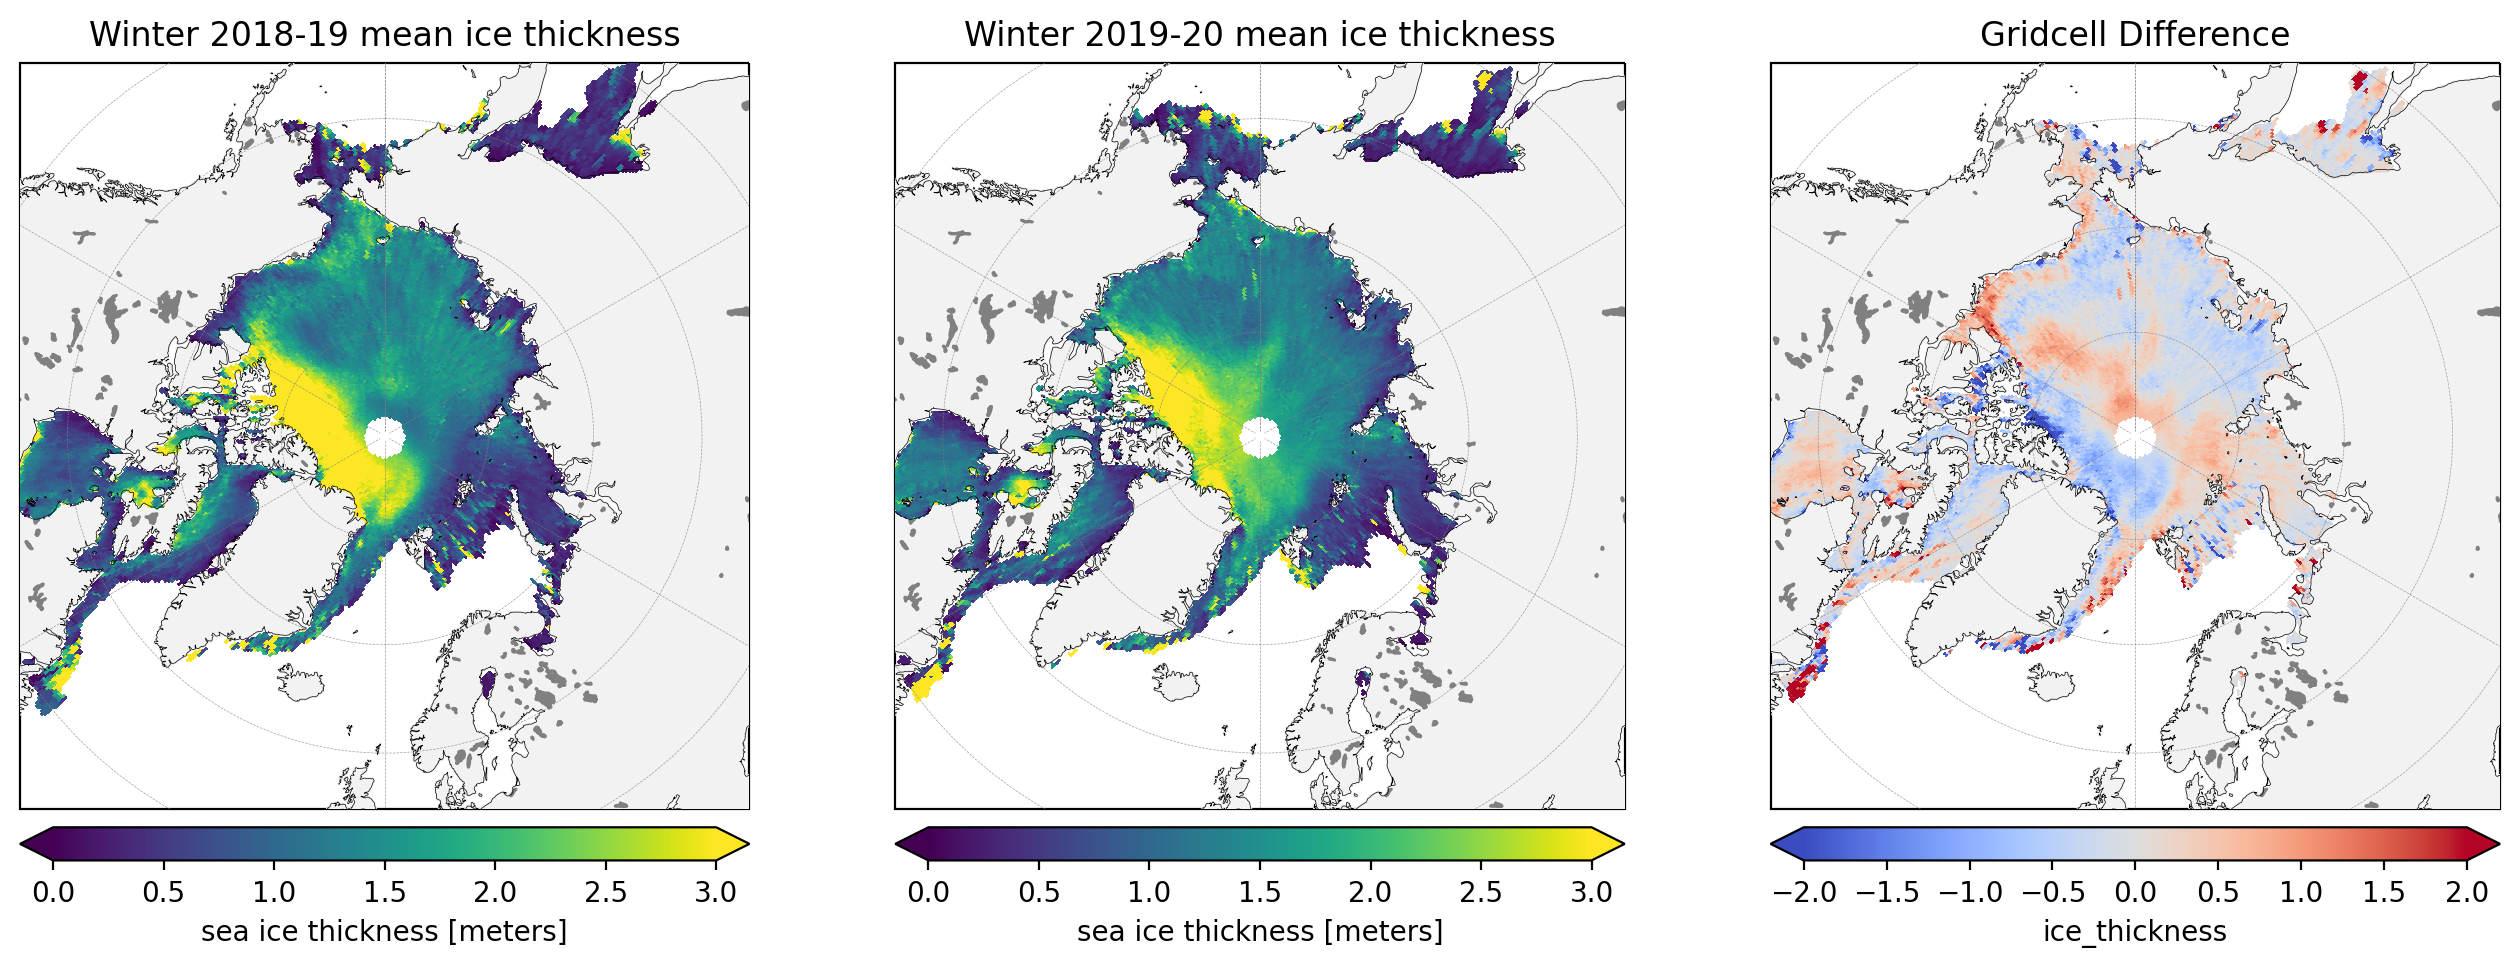

In [9]:
arcticComparisonMaps(thickness_av_winter1, thickness_av_winter2, 
                     title1="Winter 2018-19 mean ice thickness", title2="Winter 2019-20 mean ice thickness",
                     vmin=0, vmax=3, vmin_diff=-2, vmax_diff=2)
